In [1]:
import torch

In [2]:
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
from PIL import Image
import torchvision
import pathlib
import numpy as np
import cv2
import os
import random
import glob
import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
transformer = transforms.Compose([
    transforms.ToTensor()
])

In [7]:
train_path = r'G:\CSE_465\project\project\Dataset'
tests_path = r'G:\CSE_465\project\project\test'

train_dataloader = DataLoader(
    torchvision.datasets.ImageFolder(train_path, transform = transformer),
    batch_size = 100,shuffle= True
)

test_dataloader = DataLoader(
    torchvision.datasets.ImageFolder(tests_path, transform = transformer),
    batch_size = 100,shuffle= True
)

In [8]:
classes = ['Bear','Camel','Cat','Dear','Dog','Elephant','Fish','Hamstar','Rakun','Tiger']

torch.Size([100, 3, 64, 64]) torch.Size([100])


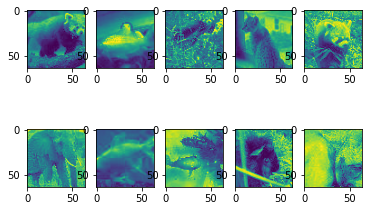

10


In [10]:
example = iter(train_dataloader)
samples, labels = example.next()
print(samples.shape, labels.shape)
for i in range(10):
    plt.subplot(2,5, i+1)
    plt.imshow(samples[i][0])
plt.show()
print(len(train_dataloader))

In [19]:
class FeedForward(torch.nn.Module):
    def __init__(self, input_size, hidden_size, numclasses):
        super(FeedForward, self).__init__()
        self.l1 = torch.nn.Linear(input_size, hidden_size)
        self.relu1 = torch.nn.ReLU()
        self.l2 = torch.nn.Linear(hidden_size,numclasses)
#         self.relu2 = torch.nn.ReLU()
#         self.l3 = torch.nn.Linear(20,numclasses)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu1(out)
        out = self.l2(out)
#         out = self.relu2(out)
#         out = self.l3(out)
        return out


In [ ]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.con1 = torch.nn.Conv2d(in_channels=3, out_channels=12)
        

In [23]:
model = FeedForward((3*64*64), 100, 10)
model = model.to(device)
epoch = 200

loss_arr = []

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

n_total_stapes = len(train_dataloader)
for  epochs in range(epoch):
    model.train()
    train_loss = 0.0
    train_accuricy = 0.0
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.reshape(-1, (3*64*64)).to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.cpu().data*10
        
        _,prediction = torch.max(outputs.data,1)
        
        train_accuricy+= int(torch.sum(prediction==labels.data))
        
    train_accuricy = train_accuricy/1000
    train_loss = train_loss/1000
    loss_arr.append(train_loss)
    
    model.eval()
    test_accuricy= 0.0
    
    for i, (images, labels) in enumerate(test_dataloader):
        images = images.reshape(-1, (3*64*64)).to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _,prediction = torch.max(outputs.data,1)
        
        test_accuricy+= int(torch.sum(prediction==labels.data))
        
    test_accuricy = test_accuricy/500
    print(f'Epoch {epochs+1} / {epoch} , Train Loss: {train_loss:.4f},  Train Accuricy:  {train_accuricy:.4f},   Test Accuricy:  {test_accuricy:.4f}' )   



Epoch 1 / 200 , Train Loss: 0.2307,  Train Accuricy:  0.1170,   Test Accuricy:  0.1020
Epoch 2 / 200 , Train Loss: 0.2299,  Train Accuricy:  0.1330,   Test Accuricy:  0.1120
Epoch 3 / 200 , Train Loss: 0.2294,  Train Accuricy:  0.1400,   Test Accuricy:  0.1240
Epoch 4 / 200 , Train Loss: 0.2290,  Train Accuricy:  0.1420,   Test Accuricy:  0.1420
Epoch 5 / 200 , Train Loss: 0.2287,  Train Accuricy:  0.1460,   Test Accuricy:  0.1380
Epoch 6 / 200 , Train Loss: 0.2283,  Train Accuricy:  0.1650,   Test Accuricy:  0.1560
Epoch 7 / 200 , Train Loss: 0.2280,  Train Accuricy:  0.1840,   Test Accuricy:  0.1480
Epoch 8 / 200 , Train Loss: 0.2277,  Train Accuricy:  0.1850,   Test Accuricy:  0.1560
Epoch 9 / 200 , Train Loss: 0.2274,  Train Accuricy:  0.1980,   Test Accuricy:  0.1640
Epoch 10 / 200 , Train Loss: 0.2271,  Train Accuricy:  0.1970,   Test Accuricy:  0.1640
Epoch 11 / 200 , Train Loss: 0.2268,  Train Accuricy:  0.2090,   Test Accuricy:  0.1740
Epoch 12 / 200 , Train Loss: 0.2265,  Tra

Epoch 95 / 200 , Train Loss: 0.2051,  Train Accuricy:  0.3760,   Test Accuricy:  0.2500
Epoch 96 / 200 , Train Loss: 0.2049,  Train Accuricy:  0.3900,   Test Accuricy:  0.2500
Epoch 97 / 200 , Train Loss: 0.2046,  Train Accuricy:  0.3870,   Test Accuricy:  0.2480
Epoch 98 / 200 , Train Loss: 0.2046,  Train Accuricy:  0.3810,   Test Accuricy:  0.2420
Epoch 99 / 200 , Train Loss: 0.2042,  Train Accuricy:  0.3800,   Test Accuricy:  0.2540
Epoch 100 / 200 , Train Loss: 0.2040,  Train Accuricy:  0.3840,   Test Accuricy:  0.2420
Epoch 101 / 200 , Train Loss: 0.2038,  Train Accuricy:  0.3890,   Test Accuricy:  0.2500
Epoch 102 / 200 , Train Loss: 0.2036,  Train Accuricy:  0.3840,   Test Accuricy:  0.2380
Epoch 103 / 200 , Train Loss: 0.2034,  Train Accuricy:  0.3830,   Test Accuricy:  0.2440
Epoch 104 / 200 , Train Loss: 0.2031,  Train Accuricy:  0.3860,   Test Accuricy:  0.2560
Epoch 105 / 200 , Train Loss: 0.2028,  Train Accuricy:  0.3840,   Test Accuricy:  0.2620
Epoch 106 / 200 , Train Lo

Epoch 188 / 200 , Train Loss: 0.1868,  Train Accuricy:  0.4320,   Test Accuricy:  0.2660
Epoch 189 / 200 , Train Loss: 0.1865,  Train Accuricy:  0.4380,   Test Accuricy:  0.2700
Epoch 190 / 200 , Train Loss: 0.1864,  Train Accuricy:  0.4370,   Test Accuricy:  0.2740
Epoch 191 / 200 , Train Loss: 0.1863,  Train Accuricy:  0.4420,   Test Accuricy:  0.2660
Epoch 192 / 200 , Train Loss: 0.1861,  Train Accuricy:  0.4400,   Test Accuricy:  0.2680
Epoch 193 / 200 , Train Loss: 0.1859,  Train Accuricy:  0.4360,   Test Accuricy:  0.2700
Epoch 194 / 200 , Train Loss: 0.1857,  Train Accuricy:  0.4440,   Test Accuricy:  0.2720
Epoch 195 / 200 , Train Loss: 0.1855,  Train Accuricy:  0.4380,   Test Accuricy:  0.2680
Epoch 196 / 200 , Train Loss: 0.1854,  Train Accuricy:  0.4400,   Test Accuricy:  0.2680
Epoch 197 / 200 , Train Loss: 0.1852,  Train Accuricy:  0.4450,   Test Accuricy:  0.2760
Epoch 198 / 200 , Train Loss: 0.1851,  Train Accuricy:  0.4420,   Test Accuricy:  0.2840
Epoch 199 / 200 , Tra

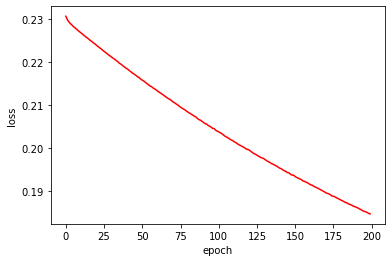

In [26]:
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.plot(np.array(loss_arr), 'red')

In [90]:
def Prediction(image_path , transformer):
    image = Image.open(image_path)
    image_tensor = transformer(image).float()
    image_tensor = image_tensor.reshape(-1,(3*64*64))
    image_tensor = image_tensor.unsqueeze_(0)
    image_tensor.to(device)
       
        
    input = Variable(image_tensor).to(device)

    output = model(input)
    output = output.cpu()
    index = output.data.numpy().argmax()
    
    pred = classes[index]
    
    return pred


In [141]:
# test_img_path = glob.glob(pred_path+'/*.JPEG')
# # print(test_img_path)
# pred_dict={}
# # for i in test_img_path:
# #     pred_dict[i[i.rfind('/')+1:]]=Prediction(i, transformer)
# #     print(i)
Prediction("G:/CSE_465/project/project/n02504458_343.JPEG", transformer)

'Elephant'

In [20]:
# pred_dict

In [21]:
# image = Image.open("G:/CSE_465/project/project/test/n02437312_292.JPEG")
# image = transformer(image)
# image = image.reshape(-1,(3*64*64))
# print(image.shape)

In [43]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# batch_size = 4
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
